# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

In [1]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import set_config
set_config(display="diagram")

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import difflib

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

The goal is to find a set of features found in the use car data that have the greatest influence on price.  The data will first be examined for any useful transformations for numerical features using scalarization or polynomial expansion while categorical string data could be transformed with one-hot encoding.  Various regression models can be trained on a subset of training data and predictions can be from the hold outs.  Examining the error margins of each model and determing the 

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [2]:
cars = pd.read_csv('data/vehicles.csv')

In [3]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [4]:
cars.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [5]:
cars.describe()

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


## Fix the NaN
So many nan values revealed, check how many total locations have nans.
I might be able to simply remove the rows for col of low percentages of NaN values.
The features with high Nan values should definitely be examined for possible transformations.


In [6]:
# view number of nan values as fraction
cars.isna().sum() / cars.shape[0]

id              0.000000
region          0.000000
price           0.000000
year            0.002823
manufacturer    0.041337
model           0.012362
condition       0.407852
cylinders       0.416225
fuel            0.007058
odometer        0.010307
title_status    0.019308
transmission    0.005988
VIN             0.377254
drive           0.305863
size            0.717675
type            0.217527
paint_color     0.305011
state           0.000000
dtype: float64

In [7]:
sum(cars.apply(lambda x: sum(x.isnull().values), axis = 1)>0)

392012

# Check the VIN
VIN is probably useless data, possibly drop the column since its 37% nan
(or do we have duplicate car values)

In [9]:
len(cars['VIN'].unique()) / cars.shape[0]
print(cars['VIN'].unique()[:10])
print(cars.query('VIN == "3GTP1VEC4EG551563"'))

[nan '3GTP1VEC4EG551563' '1GCSCSE06AZ123805' '3GCPWCED5LG130317'
 '5TFRM5F17HX120972' '1GT220CG8CZ231238' '1GCVKREH6GZ228691'
 '1GCHTCE37G1186784' '1G1YR3DW3B5102190' '1C4BJWDG5HL705371']
                id                region  price    year manufacturer  \
27      7316814884                auburn  33590  2014.0          gmc   
221     7316422333            birmingham  33590  2014.0          gmc   
1847    7315472478                dothan  33590  2014.0          gmc   
2309    7316827853      gadsden-anniston  33590  2014.0          gmc   
2667    7315513814  huntsville / decatur  33590  2014.0          gmc   
...            ...                   ...    ...     ...          ...   
397933  7316877834               roanoke  33590  2014.0          gmc   
414891  7316930375  appleton-oshkosh-FDL  33590  2014.0          gmc   
417051  7316841198             green bay  33590  2014.0          gmc   
419686  7316853652               madison  33590  2014.0          gmc   
422422  7316143275  

In [10]:
# there seems to be duplicates in the data given VIN, and a few inconsistent values with model
print(cars.duplicated(['VIN']).sum())
print(cars.duplicated(['VIN', 'model']).sum())

gb_model = (cars.groupby('VIN')['model'].unique().agg(len) > 1)
#print(gb_model)
print(gb_model.sum())

gb_price = (cars.groupby('VIN')['price'].unique().agg(len) > 1)
#print(gb_price)
print(gb_price.sum())



308633
288908
2430
3590


# Dropping VIN and examining 

There is a small number of duplicates with different models and prices, lets just remove duplicate VINs


In [11]:
cars_ddvin = cars.drop_duplicates('VIN')
cars_ddvin.isna().sum() / cars_ddvin.shape[0]

id              0.000000
region          0.000000
price           0.000000
year            0.005023
manufacturer    0.025946
model           0.005962
condition       0.483437
cylinders       0.405769
fuel            0.013861
odometer        0.013328
title_status    0.030775
transmission    0.010461
VIN             0.000008
drive           0.231287
size            0.743672
type            0.136875
paint_color     0.259482
state           0.000000
dtype: float64

In [12]:
cars_ddvin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118247 entries, 0 to 426833
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            118247 non-null  int64  
 1   region        118247 non-null  object 
 2   price         118247 non-null  int64  
 3   year          117653 non-null  float64
 4   manufacturer  115179 non-null  object 
 5   model         117542 non-null  object 
 6   condition     61082 non-null   object 
 7   cylinders     70266 non-null   object 
 8   fuel          116608 non-null  object 
 9   odometer      116671 non-null  float64
 10  title_status  114608 non-null  object 
 11  transmission  117010 non-null  object 
 12  VIN           118246 non-null  object 
 13  drive         90898 non-null   object 
 14  size          30310 non-null   object 
 15  type          102062 non-null  object 
 16  paint_color   87564 non-null   object 
 17  state         118247 non-null  object 
dtypes: f

# Verify data
Verifying that dropping VIN did not affect the mean too much.
Unfortunately it does but as we see later there are some outlier prices as seen in 'max'.
Then I check how much data we will have after dropping na for all other colums


In [50]:
print(cars_ddvin.describe())
print(cars.describe())
cars_ddvin.describe() - cars.describe()

                 id         price           year      odometer
count  1.182470e+05  1.182470e+05  117653.000000  1.166710e+05
mean   7.312179e+09  1.782777e+04    2012.661037  9.013283e+04
std    4.239264e+06  3.599125e+05       6.808482  9.664870e+04
min    7.222696e+09  0.000000e+00    1900.000000  0.000000e+00
25%    7.309408e+09  6.000000e+03    2010.000000  4.022550e+04
50%    7.313622e+09  1.322200e+04    2014.000000  8.441400e+04
75%    7.315626e+09  2.398800e+04    2017.000000  1.266595e+05
max    7.317099e+09  1.234568e+08    2022.000000  1.000000e+07
                 id         price           year      odometer
count  4.268800e+05  4.268800e+05  425675.000000  4.224800e+05
mean   7.311487e+09  7.519903e+04    2011.235191  9.804333e+04
std    4.473170e+06  1.218228e+07       9.452120  2.138815e+05
min    7.207408e+09  0.000000e+00    1900.000000  0.000000e+00
25%    7.308143e+09  5.900000e+03    2008.000000  3.770400e+04
50%    7.312621e+09  1.395000e+04    2013.000000  8.554

,id,price,year,odometer
count,-3.086330e+05,-3.086330e+05,-308022.000000,-305809.000000
mean,6.924832e+05,-5.737126e+04,1.425846,-7910.504365
std,-2.339060e+05,-1.182237e+07,-2.643638,-117232.801399
min,1.528780e+07,0.000000e+00,0.000000,0.000000
25%,1.264492e+06,1.000000e+02,2.000000,2521.500000
50%,1.000974e+06,-7.280000e+02,1.000000,-1134.000000
75%,3.720315e+05,-2.497750e+03,0.000000,-6883.000000
max,-2.094000e+03,-3.613472e+09,0.000000,0.000000


In [14]:
print(cars_ddvin.dropna().info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21741 entries, 126 to 426833
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            21741 non-null  int64  
 1   region        21741 non-null  object 
 2   price         21741 non-null  int64  
 3   year          21741 non-null  float64
 4   manufacturer  21741 non-null  object 
 5   model         21741 non-null  object 
 6   condition     21741 non-null  object 
 7   cylinders     21741 non-null  object 
 8   fuel          21741 non-null  object 
 9   odometer      21741 non-null  float64
 10  title_status  21741 non-null  object 
 11  transmission  21741 non-null  object 
 12  VIN           21741 non-null  object 
 13  drive         21741 non-null  object 
 14  size          21741 non-null  object 
 15  type          21741 non-null  object 
 16  paint_color   21741 non-null  object 
 17  state         21741 non-null  object 
dtypes: float64(2), int64(2)

# Transform instead of drop

I now determine if some of these high nan count features can be transformed instead of deleted
Its reasonable to assume that 'model' values can be used to propgate to features that are structural like 'size', 'type', 'drive', and 'cylinders'

In [51]:
for col in ['condition', 'cylinders', 'drive', 'size', 'type', 'paint_color']:
    print(col, cars[col].unique())

condition [nan 'good' 'excellent' 'fair' 'like new' 'new' 'salvage']
cylinders [nan '8 cylinders' '6 cylinders' '4 cylinders' '5 cylinders' 'other'
 '3 cylinders' '10 cylinders' '12 cylinders']
drive [nan 'rwd' '4wd' 'fwd']
size [nan 'full-size' 'mid-size' 'compact' 'sub-compact']
type [nan 'pickup' 'truck' 'other' 'coupe' 'SUV' 'hatchback' 'mini-van' 'sedan'
 'offroad' 'bus' 'van' 'convertible' 'wagon']
paint_color [nan 'white' 'blue' 'red' 'black' 'silver' 'grey' 'brown' 'yellow'
 'orange' 'green' 'custom' 'purple']


In [16]:
# Perhaps the model can be used to predict the size and others, if we groupby model we may save some size dataa
obj = cars_ddvin.groupby('model')[['size', 'type', 'drive', 'cylinders']].fillna(method='ffill')
print(type(obj))
obj.info()

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
Int64Index: 117542 entries, 27 to 426833
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   size       89743 non-null   object
 1   type       114946 non-null  object
 2   drive      111211 non-null  object
 3   cylinders  106704 non-null  object
dtypes: object(4)
memory usage: 8.5+ MB


In [17]:
# Replace the original nans
cars_ddvin_fillna = cars_ddvin.fillna(obj)
cars_ddvin_fillna.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118247 entries, 0 to 426833
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            118247 non-null  int64  
 1   region        118247 non-null  object 
 2   price         118247 non-null  int64  
 3   year          117653 non-null  float64
 4   manufacturer  115179 non-null  object 
 5   model         117542 non-null  object 
 6   condition     61082 non-null   object 
 7   cylinders     107122 non-null  object 
 8   fuel          116608 non-null  object 
 9   odometer      116671 non-null  float64
 10  title_status  114608 non-null  object 
 11  transmission  117010 non-null  object 
 12  VIN           118246 non-null  object 
 13  drive         111813 non-null  object 
 14  size          90059 non-null   object 
 15  type          115550 non-null  object 
 16  paint_color   87564 non-null   object 
 17  state         118247 non-null  object 
dtypes: f

In [18]:
# see what happens when we drop the rest of rows with NaNs
cars_ddvin_fillna_dropna = cars_ddvin_fillna.dropna()
cars_ddvin_fillna_dropna.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37117 entries, 126 to 426833
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            37117 non-null  int64  
 1   region        37117 non-null  object 
 2   price         37117 non-null  int64  
 3   year          37117 non-null  float64
 4   manufacturer  37117 non-null  object 
 5   model         37117 non-null  object 
 6   condition     37117 non-null  object 
 7   cylinders     37117 non-null  object 
 8   fuel          37117 non-null  object 
 9   odometer      37117 non-null  float64
 10  title_status  37117 non-null  object 
 11  transmission  37117 non-null  object 
 12  VIN           37117 non-null  object 
 13  drive         37117 non-null  object 
 14  size          37117 non-null  object 
 15  type          37117 non-null  object 
 16  paint_color   37117 non-null  object 
 17  state         37117 non-null  object 
dtypes: float64(2), int64(2)

In [19]:
print(cars_ddvin_fillna.describe())
cars_ddvin_fillna.describe() - cars_ddvin_fillna_dropna.describe()

                 id         price           year      odometer
count  1.182470e+05  1.182470e+05  117653.000000  1.166710e+05
mean   7.312179e+09  1.782777e+04    2012.661037  9.013283e+04
std    4.239264e+06  3.599125e+05       6.808482  9.664870e+04
min    7.222696e+09  0.000000e+00    1900.000000  0.000000e+00
25%    7.309408e+09  6.000000e+03    2010.000000  4.022550e+04
50%    7.313622e+09  1.322200e+04    2014.000000  8.441400e+04
75%    7.315626e+09  2.398800e+04    2017.000000  1.266595e+05
max    7.317099e+09  1.234568e+08    2022.000000  1.000000e+07


,id,price,year,odometer
count,8.113000e+04,81130.000000,80536.000000,79554.000000
mean,2.876484e+04,717.188501,1.579161,-16758.332930
std,1.006123e+05,-280937.408046,-0.325137,-1620.188591
min,-7.889233e+07,0.000000,-5.000000,0.000000
25%,-1.093585e+05,1.000000,2.000000,-24774.500000
50%,1.591590e+05,2322.000000,2.000000,-19456.000000
75%,1.563400e+05,5993.000000,2.000000,-14595.500000
max,0.000000e+00,0.000000,0.000000,1.000000


# Satisfied NaNs
I think it looks good, we got back 15,000+ data points by filling na values with same 'model' types.
The mean values are not that different so we didn't bias the price/year/odometer but the other features
could have been biased.  Some data entries may be bad from some given location/manufacturere depending how collected.

In [53]:
obj_col = list(cars_ddvin_fillna_dropna.select_dtypes(include=['object']).columns)
for col in obj_col:
    ulen = len(cars_ddvin_fillna_dropna[col].unique())
    print(col, ulen)

region 390
manufacturer 41
model 5075
condition 6
cylinders 8
fuel 5
title_status 6
transmission 3
VIN 37117
drive 3
size 4
type 13
paint_color 12
state 51


# Manufacturer Models
Determine why so many models, look for close values
(try manufacturer as well)


In [22]:

#col = 'manufacturer'
col = 'model'
tmpdf = cars_ddvin_fillna_dropna[['manufacturer', 'model']].sample(n=1000)

print(tmpdf.value_counts())
for i in range(5):
    close_match = tmpdf[col].apply(lambda x: (x, difflib.get_close_matches(x, tmpdf[tmpdf[col] != x][col])))
    # what-if we replaced with close_matches, how many models would we have?
    for x, y in close_match:
        if (len(y) > 0):
            #print (x)
            tmpdf[col] = tmpdf[col].replace(x, y[0])

    print(len(tmpdf[col].unique()))

print(tmpdf.value_counts())



manufacturer  model                 
ford          f-150                     23
chevrolet     silverado 1500            20
ram           1500                      12
jeep          grand cherokee            12
honda         accord                    10
                                        ..
ford          f450                       1
              f350 crew cab              1
              f350 4 wd dull/4dr         1
              f250 super duty lariat     1
volvo         xc90 awd                   1
Length: 563, dtype: int64
238
172
167
167
167
manufacturer   model                    
chevrolet      silverado 2500hd lt          48
ford           f550                         44
jeep           grand cherokee laredo 4x4    21
gmc            silverado 2500hd lt          21
ram            f550                         18
                                            ..
mercedes-benz  grand caravan                 1
               glc300 glc 300                1
               f550        

# Final cut...
There are too many models to be meaningful.  perhaps a model per manufacturer study could be had.
This probably should be done before dropping duplicates.
My goal is going to be find as many valid data entries and keep as many features as possible.
I have an idea that once a good regression model is built and a smaller feature list is dicovered, then go back and validate with more data where those rows may have been removed because of other features having Nan values?

Once unnecessary features are removed (for reasons that there are just too many categories) we can convert the remaining 'object' types using "get_dummies".

In [23]:
# Drop model(too many) region(too many), ID, and VIN 
final_cols = cars_ddvin_fillna_dropna.drop(['model', 'region', 'id', 'VIN'], axis=1)

# I think it will be difficult to use manufaturer or state as a feature.

# Use one-hot encoding on rest of objects
final_obj_cols = list(final_cols.select_dtypes(include=['object']).columns)
print(final_obj_cols)
tmp_df = pd.get_dummies(final_cols[final_obj_cols])
tmp_df.head()
print(tmp_df.info())
print(tmp_df.shape)

final = final_cols.drop(final_obj_cols, axis=1)
final = final.join(tmp_df)
print(final.shape)
print(final.columns)

['manufacturer', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color', 'state']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 37117 entries, 126 to 426833
Columns: 152 entries, manufacturer_acura to state_wy
dtypes: uint8(152)
memory usage: 5.7 MB
None
(37117, 152)
(37117, 155)
Index(['price', 'year', 'odometer', 'manufacturer_acura',
       'manufacturer_alfa-romeo', 'manufacturer_aston-martin',
       'manufacturer_audi', 'manufacturer_bmw', 'manufacturer_buick',
       'manufacturer_cadillac',
       ...
       'state_sd', 'state_tn', 'state_tx', 'state_ut', 'state_va', 'state_vt',
       'state_wa', 'state_wi', 'state_wv', 'state_wy'],
      dtype='object', length=155)


### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [24]:
price = final['price']
dataf = final.drop('price', axis=1)

X_train, X_test, y_train, y_test = train_test_split(dataf, price, random_state=42, test_size=0.3)

In [25]:
# most of the work was performed already in the previous section

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [26]:
# Try a simple linear regression
linreg = LinearRegression()
linreg.fit(X_train, y_train)
train_preds = linreg.predict(X_train)
test_preds = linreg.predict(X_test)
selector_train_mse = mean_squared_error(y_train, train_preds)
selector_test_mse = mean_squared_error(y_test, test_preds)

print(f'Train MSE: {selector_train_mse}')
print(f'Test MSE: {selector_test_mse}')

Train MSE: 88769297.83260603
Test MSE: 1368469926629.2068


In [27]:
# Try to find a set of features that influence price using method found in codio 9.7 using gridsearchcv
selector_pipe = Pipeline([('selector', SequentialFeatureSelector(LinearRegression())),
                         ('model', LinearRegression())])

In [28]:
param_dict = {'selector__n_features_to_select': [2, 3, 4, 5]}
selector_grid = GridSearchCV(selector_pipe, param_grid=param_dict, verbose=2)
selector_grid.fit(X_train, y_train)
train_preds = selector_grid.predict(X_train)
test_preds = selector_grid.predict(X_test)
selector_train_mse = mean_squared_error(y_train, train_preds)
selector_test_mse = mean_squared_error(y_test, test_preds)

print(f'Train MSE: {selector_train_mse}')
print(f'Test MSE: {selector_test_mse}')

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ...................selector__n_features_to_select=2; total time=   2.2s
[CV] END ...................selector__n_features_to_select=2; total time=   2.2s
[CV] END ...................selector__n_features_to_select=2; total time=   2.2s
[CV] END ...................selector__n_features_to_select=2; total time=   2.2s
[CV] END ...................selector__n_features_to_select=2; total time=   2.3s
[CV] END ...................selector__n_features_to_select=3; total time=   3.8s
[CV] END ...................selector__n_features_to_select=3; total time=   4.1s
[CV] END ...................selector__n_features_to_select=3; total time=   4.0s
[CV] END ...................selector__n_features_to_select=3; total time=   4.1s
[CV] END ...................selector__n_features_to_select=3; total time=   3.8s
[CV] END ...................selector__n_features_to_select=4; total time=   5.2s
[CV] END ...................selector__n_features_

In [29]:
# Code from 9.7
# Comparing to linear regression the Test MSE was much better.
best_estimator = selector_grid.best_estimator_
best_selector = best_estimator.named_steps['selector']
best_model = selector_grid.best_estimator_.named_steps['model']
feature_names = X_train.columns[best_selector.get_support()]
coefs = best_model.coef_

print(best_estimator)
print(f'Features from best selector: {feature_names}.')
print('Coefficient values: ')
print('===================')
pd.DataFrame([coefs.T], columns = feature_names, index = ['model'])

Pipeline(steps=[('selector',
                 SequentialFeatureSelector(estimator=LinearRegression(),
                                           n_features_to_select=5)),
                ('model', LinearRegression())])
Features from best selector: Index(['year', 'condition_like new', 'cylinders_8 cylinders', 'fuel_diesel',
       'drive_fwd'],
      dtype='object').
Coefficient values: 


,year,condition_like new,cylinders_8 cylinders,fuel_diesel,drive_fwd
model,485.102969,4865.768533,5465.746419,11891.416352,-5466.776708


In [30]:
# I believe the larger MSE on the test data indicates overfitting.
# Try Ridge with different alphas to see if it produces a better MSE with the selector and a scaler
ridge_param_dict = {'ridge__alpha': np.logspace(0, 10, 50) }
#                    'selector__n_features_to_select': [2, 3, 4, 5] }
ridge_pipe = Pipeline([#('selector', SequentialFeatureSelector(Ridge())),
                       ('scaler', StandardScaler()), 
                      ('ridge', Ridge())])
ridge_grid = GridSearchCV(ridge_pipe, param_grid=ridge_param_dict, verbose=2)
ridge_grid.fit(X_train, y_train)
ridge_train_preds = ridge_grid.predict(X_train)
ridge_test_preds = ridge_grid.predict(X_test)
ridge_train_mse = mean_squared_error(y_train, ridge_train_preds)
ridge_test_mse = mean_squared_error(y_test, ridge_test_preds)
### END SOLUTION

# ANSWER CHECK
print(f'Train MSE: {ridge_train_mse}')
print(f'Test MSE: {ridge_test_mse}')


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END ...................................ridge__alpha=1.0; total time=   0.0s
[CV] END ...................................ridge__alpha=1.0; total time=   0.0s
[CV] END ...................................ridge__alpha=1.0; total time=   0.0s
[CV] END ...................................ridge__alpha=1.0; total time=   0.0s
[CV] END ...................................ridge__alpha=1.0; total time=   0.0s
[CV] END .....................ridge__alpha=1.599858719606058; total time=   0.0s
[CV] END .....................ridge__alpha=1.599858719606058; total time=   0.0s
[CV] END .....................ridge__alpha=1.599858719606058; total time=   0.0s
[CV] END .....................ridge__alpha=1.599858719606058; total time=   0.0s
[CV] END .....................ridge__alpha=1.599858719606058; total time=   0.0s
[CV] END ....................ridge__alpha=2.5595479226995357; total time=   0.0s
[CV] END ....................ridge__alpha=2.559

[CV] END .....................ridge__alpha=12067.92640639329; total time=   0.0s
[CV] END .....................ridge__alpha=12067.92640639329; total time=   0.0s
[CV] END .....................ridge__alpha=12067.92640639329; total time=   0.0s
[CV] END ....................ridge__alpha=19306.977288832495; total time=   0.0s
[CV] END ....................ridge__alpha=19306.977288832495; total time=   0.0s
[CV] END ....................ridge__alpha=19306.977288832495; total time=   0.0s
[CV] END ....................ridge__alpha=19306.977288832495; total time=   0.0s
[CV] END ....................ridge__alpha=19306.977288832495; total time=   0.0s
[CV] END .....................ridge__alpha=30888.43596477485; total time=   0.0s
[CV] END .....................ridge__alpha=30888.43596477485; total time=   0.0s
[CV] END .....................ridge__alpha=30888.43596477485; total time=   0.0s
[CV] END .....................ridge__alpha=30888.43596477485; total time=   0.0s
[CV] END ...................

[CV] END .....................ridge__alpha=232995181.0515372; total time=   0.0s
[CV] END .....................ridge__alpha=232995181.0515372; total time=   0.0s
[CV] END .....................ridge__alpha=232995181.0515372; total time=   0.0s
[CV] END .....................ridge__alpha=232995181.0515372; total time=   0.0s
[CV] END .....................ridge__alpha=232995181.0515372; total time=   0.0s
[CV] END .....................ridge__alpha=372759372.0314938; total time=   0.0s
[CV] END .....................ridge__alpha=372759372.0314938; total time=   0.0s
[CV] END .....................ridge__alpha=372759372.0314938; total time=   0.0s
[CV] END .....................ridge__alpha=372759372.0314938; total time=   0.0s
[CV] END .....................ridge__alpha=372759372.0314938; total time=   0.0s
[CV] END .....................ridge__alpha=596362331.6594636; total time=   0.0s
[CV] END .....................ridge__alpha=596362331.6594636; total time=   0.0s
[CV] END ...................

In [31]:
# Why are these models so bad?
print(np.mean(ridge_test_preds))
print(np.mean(y_test))



13752.949836707492
24914.850215517243


In [32]:
best_estimator = ridge_grid.best_estimator_
print(best_estimator)

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', Ridge(alpha=7543.120063354622))])


In [33]:
# Try again to get features
ridge_param_dict = {'selector__n_features_to_select': [4, 5, 6, 7] }
ridge_pipe = Pipeline([('selector', SequentialFeatureSelector(Ridge(alpha=7543.12))),
                       ('scaler', StandardScaler()), 
                      ('ridge', Ridge(alpha=7543.12))])
ridge_grid = GridSearchCV(ridge_pipe, param_grid=ridge_param_dict, verbose=2)
ridge_grid.fit(X_train, y_train)
ridge_train_preds = ridge_grid.predict(X_train)
ridge_test_preds = ridge_grid.predict(X_test)
ridge_train_mse = mean_squared_error(y_train, ridge_train_preds)
ridge_test_mse = mean_squared_error(y_test, ridge_test_preds)
### END SOLUTION

# ANSWER CHECK
print(f'Train MSE: {ridge_train_mse}')
print(f'Test MSE: {ridge_test_mse}')


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ...................selector__n_features_to_select=4; total time=   6.5s
[CV] END ...................selector__n_features_to_select=4; total time=   6.5s
[CV] END ...................selector__n_features_to_select=4; total time=   5.9s
[CV] END ...................selector__n_features_to_select=4; total time=   8.7s
[CV] END ...................selector__n_features_to_select=4; total time=   6.6s
[CV] END ...................selector__n_features_to_select=5; total time=   7.4s
[CV] END ...................selector__n_features_to_select=5; total time=   9.0s
[CV] END ...................selector__n_features_to_select=5; total time=   9.3s
[CV] END ...................selector__n_features_to_select=5; total time=   7.9s
[CV] END ...................selector__n_features_to_select=5; total time=   8.3s
[CV] END ...................selector__n_features_to_select=6; total time=   9.4s
[CV] END ...................selector__n_features_

In [34]:
# Code from 9.7
best_estimator = ridge_grid.best_estimator_
best_selector = best_estimator.named_steps['selector']
best_model = ridge_grid.best_estimator_.named_steps['ridge']
feature_names = X_train.columns[best_selector.get_support()]
coefs = best_model.coef_

print(best_estimator)
print(f'Features from best selector: {feature_names}.')
print('Coefficient values: ')
print('===================')
pd.DataFrame([coefs.T], columns = feature_names, index = ['model'])

Pipeline(steps=[('selector',
                 SequentialFeatureSelector(estimator=Ridge(alpha=7543.12),
                                           n_features_to_select=7)),
                ('scaler', StandardScaler()), ('ridge', Ridge(alpha=7543.12))])
Features from best selector: Index(['year', 'cylinders_4 cylinders', 'cylinders_8 cylinders', 'fuel_diesel',
       'drive_fwd', 'type_sedan', 'type_truck'],
      dtype='object').
Coefficient values: 


,year,cylinders_4 cylinders,cylinders_8 cylinders,fuel_diesel,drive_fwd,type_sedan,type_truck
model,2747.717398,-932.925096,1397.809625,1722.532969,-1606.44202,-853.27435,732.458166


In [35]:
# let's see the top 10 features
ridge_param_dict = {'selector__n_features_to_select': [10] }
ridge_pipe = Pipeline([('selector', SequentialFeatureSelector(Ridge(alpha=7543.12))),
                       ('scaler', StandardScaler()), 
                      ('ridge', Ridge(alpha=7543.12))])
ridge_grid = GridSearchCV(ridge_pipe, param_grid=ridge_param_dict, verbose=2)
ridge_grid.fit(X_train, y_train)
ridge_train_preds = ridge_grid.predict(X_train)
ridge_test_preds = ridge_grid.predict(X_test)
ridge_train_mse = mean_squared_error(y_train, ridge_train_preds)
ridge_test_mse = mean_squared_error(y_test, ridge_test_preds)

print(f'Train MSE: {ridge_train_mse}')
print(f'Test MSE: {ridge_test_mse}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END ..................selector__n_features_to_select=10; total time=  21.5s
[CV] END ..................selector__n_features_to_select=10; total time=  21.6s
[CV] END ..................selector__n_features_to_select=10; total time=  21.9s
[CV] END ..................selector__n_features_to_select=10; total time=  21.5s
[CV] END ..................selector__n_features_to_select=10; total time=  21.6s
Train MSE: 106446568.54749133
Test MSE: 1368499896249.103


In [36]:
# Code from 9.7
# Comparing to linear regression the Test MSE was much better.
best_estimator = ridge_grid.best_estimator_
best_selector = best_estimator.named_steps['selector']
best_model = ridge_grid.best_estimator_.named_steps['ridge']
feature_names = X_train.columns[best_selector.get_support()]
coefs = best_model.coef_

print(best_estimator)
print(f'Features from best selector: {feature_names}.')
print('Coefficient values: ')
print('===================')
pd.DataFrame([coefs.T], columns = feature_names, index = ['model'])

Pipeline(steps=[('selector',
                 SequentialFeatureSelector(estimator=Ridge(alpha=7543.12),
                                           n_features_to_select=10)),
                ('scaler', StandardScaler()), ('ridge', Ridge(alpha=7543.12))])
Features from best selector: Index(['year', 'condition_like new', 'cylinders_4 cylinders',
       'cylinders_8 cylinders', 'fuel_diesel', 'fuel_gas', 'drive_fwd',
       'size_full-size', 'type_sedan', 'type_truck'],
      dtype='object').
Coefficient values: 


,year,condition_like new,cylinders_4 cylinders,cylinders_8 cylinders,fuel_diesel,fuel_gas,drive_fwd,size_full-size,type_sedan,type_truck
model,2627.362889,1126.451739,-841.752317,1314.811712,1440.470502,-483.848112,-1597.759594,455.694678,-817.402174,700.430873


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [37]:
# The mse is too high for test data
# I think we should ry a polynomial with the year, condition, cyclinders, fuel, drive, size, type
# As these are apparently the best predictors of determining pricing.
features = ['price', 'year', 'condition', 'fuel', 'cylinders', 'size', 'drive', 'type']
final_cols = final_cols[features]
final_obj_cols = list(final_cols.select_dtypes(include=['object']).columns)
tmp_df = pd.get_dummies(final_cols[final_obj_cols])
tmp_df.head()

final = final_cols.drop(final_obj_cols, axis=1)
final = final.join(tmp_df)

price = final['price']
dataf = final.drop('price', axis=1)

X_train, X_test, y_train, y_test = train_test_split(dataf, price, random_state=42, test_size=0.3)

In [38]:
# found out >3 fails...
ridge_param_dict = {'poly_features__degree': [2, 3] }
ridge_pipe = Pipeline([ ('poly_features', PolynomialFeatures(include_bias = False)),
                        ('scaler', StandardScaler()), 
                        ('ridge', Ridge(alpha=7543.12))])
ridge_grid = GridSearchCV(ridge_pipe, param_grid=ridge_param_dict, verbose=2)

In [39]:
ridge_grid.fit(X_train, y_train)
ridge_train_preds = ridge_grid.predict(X_train)
ridge_test_preds = ridge_grid.predict(X_test)
ridge_train_mse = mean_squared_error(y_train, ridge_train_preds)
ridge_test_mse = mean_squared_error(y_test, ridge_test_preds)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END ............................poly_features__degree=2; total time=   0.7s
[CV] END ............................poly_features__degree=2; total time=   0.7s
[CV] END ............................poly_features__degree=2; total time=   0.6s
[CV] END ............................poly_features__degree=2; total time=   0.6s
[CV] END ............................poly_features__degree=2; total time=   0.6s
[CV] END ............................poly_features__degree=3; total time=  54.6s
[CV] END ............................poly_features__degree=3; total time=  49.6s
[CV] END ............................poly_features__degree=3; total time=  47.3s
[CV] END ............................poly_features__degree=3; total time=  46.3s
[CV] END ............................poly_features__degree=3; total time=  47.5s


In [40]:
print(f'Train MSE: {ridge_train_mse}')
print(f'Test MSE: {ridge_test_mse}')

Train MSE: 93863549.59982513
Test MSE: 1368517975705.1187


In [41]:
# Code from 9.7
# Comparing to linear regression the Test MSE was much better.
best_estimator = ridge_grid.best_estimator_
print(best_estimator)

Pipeline(steps=[('poly_features', PolynomialFeatures(include_bias=False)),
                ('scaler', StandardScaler()), ('ridge', Ridge(alpha=7543.12))])


In [42]:
# poly didn't seem to help
# I'm probably missing something basic here

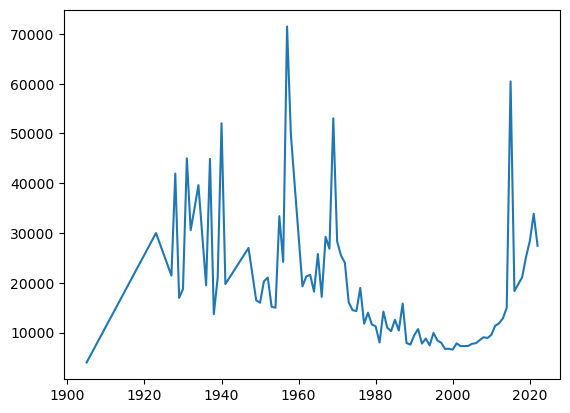

In [43]:
# plot mean price per year
gp_price = final.groupby('year')['price']
plt.plot(gp_price.mean())

1281699.7620843835
35394
37117


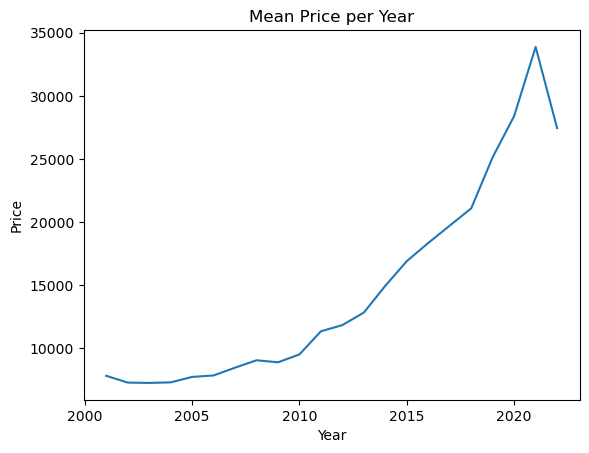

year    condition
2001.0  excellent    166
        good         142
        fair          27
        like new      23
        new            1
                    ... 
2021.0  new           90
        good          42
        excellent     37
        like new      13
2022.0  new           14
Name: condition, Length: 119, dtype: int64


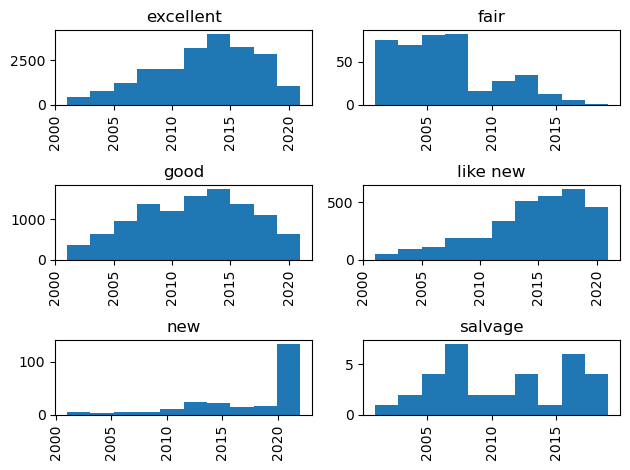

In [44]:
# I believe I shouldn't look at data before 2000 and remove the outliers
sig2 = 2 * final['price'].std()
print(sig2)
data_2000 = final[(final['year'] > 2000)]
data_2000 = data_2000[data_2000['price'] < 1000000]
print(data_2000.shape[0])
print(final.shape[0])
gp_price = data_2000.groupby('year')['price']

plt.plot(gp_price.mean())
plt.title('Mean Price per Year')
plt.xlabel('Year')
plt.ylabel('Price')
plt.show()

data_c2000 = final_cols[(final_cols['year'] > 2000)]
data_c2000 = data_c2000[data_c2000['price'] < 1000000]
gp_cond = data_c2000.groupby('year')['condition']
print(gp_cond.value_counts())

data_c2000[['year', 'condition']].hist(by=['condition'])
plt.tight_layout()

In [45]:
# try this one more time.
dataf = final[final['year'] > 2000]
dataf = dataf[dataf['price'] < 1000000]
price = dataf['price']
dataf = dataf.drop('price', axis=1)

X_train, X_test, y_train, y_test = train_test_split(dataf, price, random_state=42, test_size=0.3)

In [46]:
ridge_param_dict = {'selector__n_features_to_select': [20] }
ridge_pipe = Pipeline([('selector', SequentialFeatureSelector(Ridge(alpha=7543.12))),
                       ('scaler', StandardScaler()), 
                      ('ridge', Ridge(alpha=7543.12))])
ridge_grid = GridSearchCV(ridge_pipe, param_grid=ridge_param_dict, verbose=2)
ridge_grid.fit(X_train, y_train)
ridge_train_preds = ridge_grid.predict(X_train)
ridge_test_preds = ridge_grid.predict(X_test)
ridge_train_mse = mean_squared_error(y_train, ridge_train_preds)
ridge_test_mse = mean_squared_error(y_test, ridge_test_preds)

print(f'Train MSE: {ridge_train_mse}')
print(f'Test MSE: {ridge_test_mse}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END ..................selector__n_features_to_select=20; total time=  11.6s
[CV] END ..................selector__n_features_to_select=20; total time=  12.0s
[CV] END ..................selector__n_features_to_select=20; total time=  11.7s
[CV] END ..................selector__n_features_to_select=20; total time=  11.5s
[CV] END ..................selector__n_features_to_select=20; total time=  11.3s
Train MSE: 84113231.04879948
Test MSE: 87117007.26191893


In [47]:
# Code from 9.7
# Comparing to linear regression the Test MSE was much better.
best_estimator = ridge_grid.best_estimator_
best_selector = best_estimator.named_steps['selector']
best_model = ridge_grid.best_estimator_.named_steps['ridge']
feature_names = X_train.columns[best_selector.get_support()]
coefs = best_model.coef_

print(best_estimator)
print(f'Features from best selector: {feature_names}.')
print('Coefficient values: ')
print('===================')
print(coefs)
sort = np.argsort(coefs.T)
cdf = pd.DataFrame([coefs.T[sort]], columns = feature_names[sort], index = ['model'])
cdf

Pipeline(steps=[('selector',
                 SequentialFeatureSelector(estimator=Ridge(alpha=7543.12),
                                           n_features_to_select=20)),
                ('scaler', StandardScaler()), ('ridge', Ridge(alpha=7543.12))])
Features from best selector: Index(['year', 'condition_like new', 'fuel_diesel', 'fuel_gas', 'fuel_other',
       'cylinders_4 cylinders', 'cylinders_8 cylinders', 'size_compact',
       'size_full-size', 'drive_4wd', 'drive_fwd', 'drive_rwd', 'type_SUV',
       'type_convertible', 'type_coupe', 'type_hatchback', 'type_pickup',
       'type_sedan', 'type_truck', 'type_wagon'],
      dtype='object').
Coefficient values: 
[4081.98379216  860.00407764 1352.32424849 -619.84053053 -466.15499202
 -971.70516053 1027.01280831 -138.06119271  456.66991348  772.83901941
 -999.55620934  297.65770127 -312.16745916  509.3515429   507.85209963
 -269.32819778  695.26024172 -669.09406106  823.0109039  -329.08052007]


,drive_fwd,cylinders_4 cylinders,type_sedan,fuel_gas,fuel_other,type_wagon,type_SUV,type_hatchback,size_compact,drive_rwd,size_full-size,type_coupe,type_convertible,type_pickup,drive_4wd,type_truck,condition_like new,cylinders_8 cylinders,fuel_diesel,year
model,-999.556209,-971.705161,-669.094061,-619.840531,-466.154992,-329.08052,-312.167459,-269.328198,-138.061193,297.657701,456.669913,507.8521,509.351543,695.260242,772.839019,823.010904,860.004078,1027.012808,1352.324248,4081.983792


In [48]:
# The training/testing MSE is much better

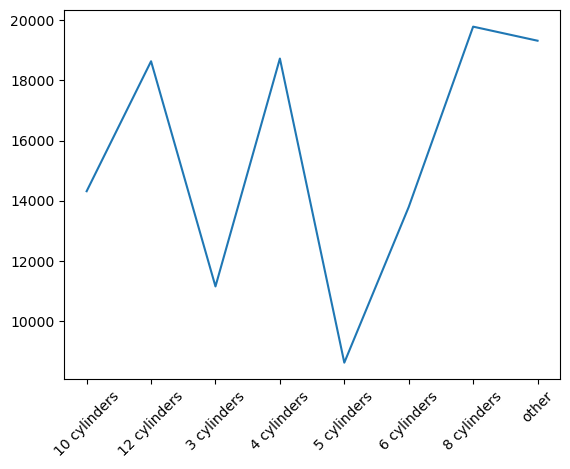

cylinders
10 cylinders      198
12 cylinders       12
3 cylinders        73
4 cylinders     14841
5 cylinders       326
6 cylinders     13014
8 cylinders      8486
other             167
Name: price, dtype: int64


In [49]:
# plot mean price per year
gp_price = final_cols.groupby('cylinders')['price']
plt.plot(gp_price.mean())
plt.xticks(rotation=45)
plt.show()
print(gp_price.size())


### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

# Report

Although it may be obvious the best predictors of price found in the used car data was 'year' and 'condition'.  The following graph shows the mean price over the past 20 years.

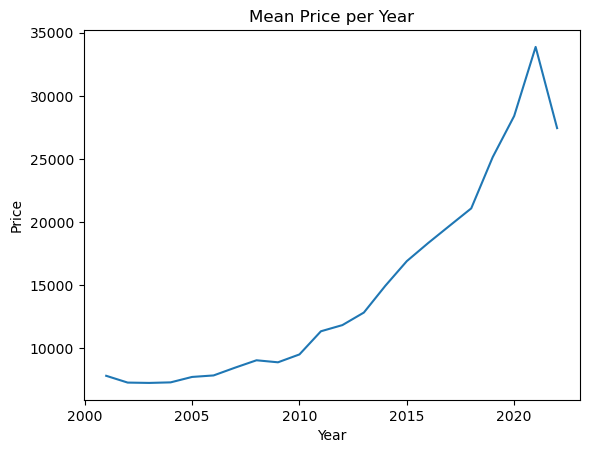

The price decreases the older the vehicle is and the older the vehicle the condition is typically worse.  The following histograms reveal the better conditon vehicles stack up more toward the current years.

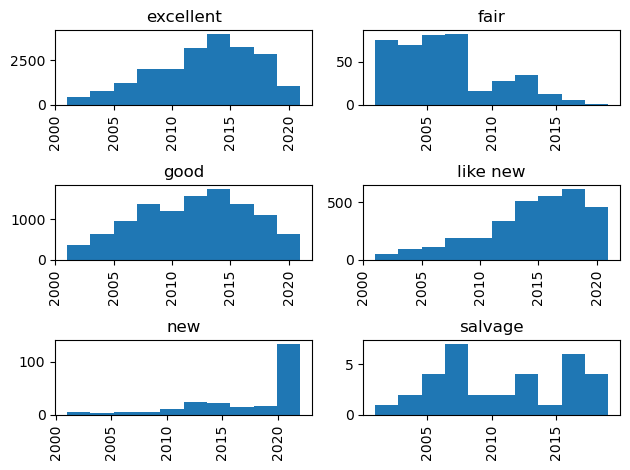

Other factors that fetch a higher price include 'diesel fuel', '8 cylinder', '4WD', 'pick-up', 'truck', or 'coupe', 'convertible', 'rear wheel drive' and 'full-size'.  And vehicles with 'front wheel drive', '4 cylinders', 'sedan', 'standard fuel' and types like 'wagon', 'SUV', 'hatchback', and 'compact' will sell at a relative discount.

I find it interesting that 'odometer' readings are not among the top contributures to pricing.  I believe further investigation is required there.

I hope you find this information meaningful when assessing your vehicle price categories, inventory and sales strategies.  With more time we could try to determine a price strategy for various vehicles sizes and types.

